In [1]:
from PIL import Image
from pathlib import Path
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.ndimage import gaussian_filter, median_filter
from scipy.signal import savgol_filter
from skimage.restoration import denoise_bilateral
from scipy.ndimage import binary_opening, binary_dilation

from sklearn.pipeline import Pipeline
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from sklearn.cluster import DBSCAN
from skimage.measure import label, regionprops, regionprops_table

load_dotenv()

True

# Load data

In [2]:
images_arr_bucket = []
for image_path in Path(os.getenv("IMAGES")).glob("*.png"):
    image = Image.open(image_path)
    image_array = np.array(image)
    images_arr_bucket.append(image_array)
len(images_arr_bucket)

7

# Pipelines

### steps

In [3]:
class GaussianFilter(BaseEstimator, TransformerMixin):
    def __init__(self, sigma=1.0):
        self.sigma = sigma

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return gaussian_filter(X, sigma=self.sigma)

class MedianFilter(BaseEstimator, TransformerMixin):
    def __init__(self, size=3, verbose=False):
        self.size = size
        self.verbose = verbose

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = median_filter(X, size=self.size)
        if self.verbose:
            plt.imshow(X)
            plt.title("MedianFilter")
            plt.show()
        return X

class BilateralFilter(BaseEstimator, TransformerMixin):
    def __init__(self, sigma_color=0.05, sigma_spatial=15):
        self.sigma_color = sigma_color
        self.sigma_spatial = sigma_spatial

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return denoise_bilateral(X, sigma_color=self.sigma_color, sigma_spatial=self.sigma_spatial, multichannel=False)


class SavgolHistogramSmoothing(BaseEstimator, TransformerMixin):
    def __init__(self, window_length=10, polyorder=2):
        self.window_length = window_length
        self.polyorder = polyorder

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        histogram, bins = np.histogram(X.flatten(), bins=256, range=[0, 256])
        smoothed_histogram = savgol_filter(histogram, window_length=self.window_length, polyorder=self.polyorder)
        smoothed_histogram = np.clip(smoothed_histogram, 0, 255)
        return smoothed_histogram



class ThresholdImageByFindPeakWidth(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        x_flat = X.flatten()
        histogram, bins = np.histogram(x_flat, bins=256, range=[0, 256])
        peaks, properties = find_peaks(histogram, prominence=1, width=20)
        X = ((X > properties["left_ips"][-1]) & (X < properties["right_ips"][-1])).astype(int)
        if self.verbose:
            plt.hist(x_flat, bins=100)
            plt.plot(peaks[-1], histogram[peaks[-1]], "x")
            plt.hlines(
                y=properties["width_heights"],
                xmin=properties["left_ips"],
                xmax=properties["right_ips"],
                color = "C1"
            )
            plt.title("ThresholdImageByFindPointBeforePeak")
            plt.show()
        return X


class ThresholdImageByFindPointBeforePeak(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        x_flat = X.flatten()
        x_flat = x_flat[(x_flat >= 5) & (x_flat <= 250)]
        histogram, bins = np.histogram(x_flat, bins=256, range=[0, 256])
        peaks, properties = find_peaks(histogram, prominence=1, width=20)
        thr_value = max(8, properties["left_ips"][0] - 20)
        X = (X < thr_value).astype(int)
        if self.verbose:
            plt.hist(x_flat, bins=100)
            plt.plot(peaks, histogram[peaks], "x")
            plt.hlines(
                y=properties["width_heights"],
                xmin=properties["left_ips"],
                xmax=properties["right_ips"],
                color = "C1"
            )
            plt.show()
            plt.title("ThresholdImageByFindPointBeforePeak")
            plt.imshow(X, vmin=0, vmax=1, cmap="binary")
            plt.show()
        return X




class BinaryOpening(BaseEstimator, TransformerMixin):
    def __init__(self, structure=np.ones((3, 3)), verbose=False):
        self.structure = structure
        self.verbose = verbose
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = binary_opening(X, structure=self.structure)
        if self.verbose:
            plt.imshow(X, vmin=0, vmax=1, cmap="binary")
            plt.title("BinaryOpening")
            plt.show()
        return X

class BinaryDilatation(BaseEstimator, TransformerMixin):
    def __init__(self, structure=np.ones((1, 1)), verbose=False):
        self.structure = structure
        self.verbose = verbose
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = binary_dilation(X, structure=self.structure)
        if self.verbose:
            plt.imshow(X, vmin=0, vmax=1, cmap="binary")
            plt.title("BinaryDilataion")
            plt.show()
        return X

class FindClustersDBSCAN(BaseEstimator, TransformerMixin):
    def __init__(self, eps=5, min_samples=50, verbose=False):
        self.eps = eps
        self.min_samples = min_samples
        self.verbose = verbose
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        coordinates = np.column_stack(np.where(X == 1))
        
        dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        labels = dbscan.fit_predict(coordinates)
        
        clustered_image = np.zeros_like(X, dtype=int) 
        
        for label in np.unique(labels):
            if label != -1:  
                mask = labels == label
                clustered_image[coordinates[mask, 0], coordinates[mask, 1]] = label + 1 
        
        regions = regionprops(clustered_image)
        for region in regions:
            if region.area < 100:
                clustered_image[region.slice] = 0
                
        if self.verbose:
            plt.imshow(clustered_image, cmap='tab20')
            plt.title("DBSCAN Clusters")
            plt.axis('off')
            plt.show()
        
        return clustered_image


### define

In [4]:
pipeline = Pipeline([
        ("smooth_filter", MedianFilter(size=5, verbose=True)),
        ("make_image_binary", ThresholdImageByFindPointBeforePeak(verbose=True)),
        ("binary_opening", BinaryOpening(structure=np.ones((3, 3)), verbose=True)),
        ("find clusters", FindClustersDBSCAN(eps=5, min_samples=60, verbose=False)),
    ])

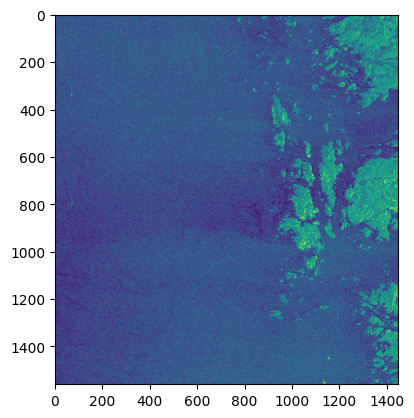

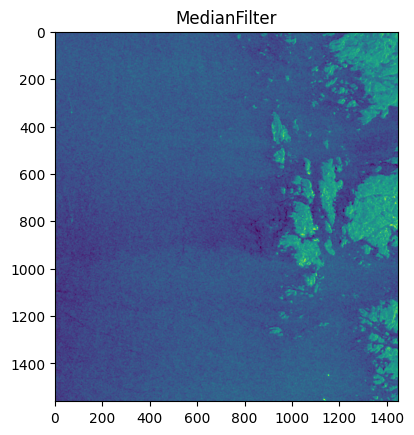

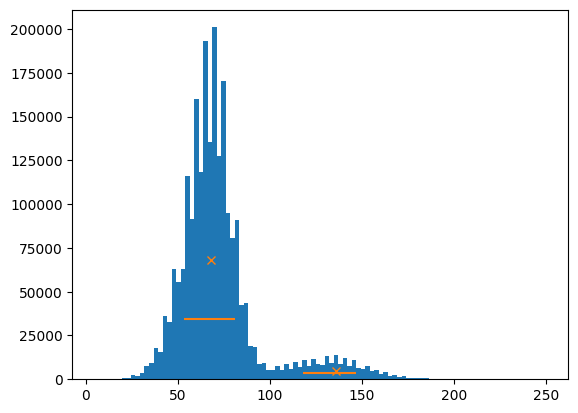

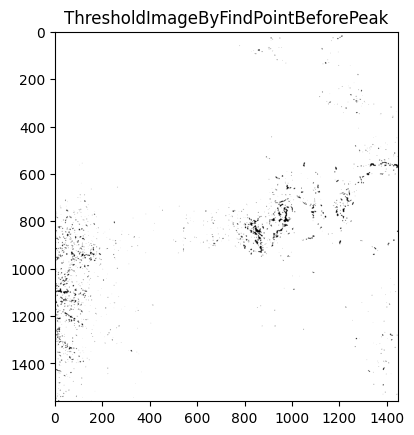

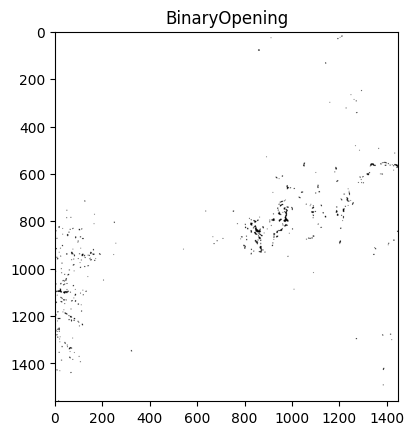

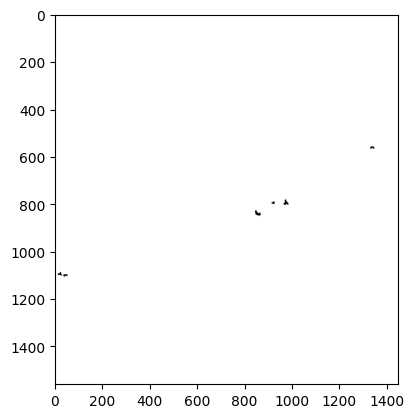

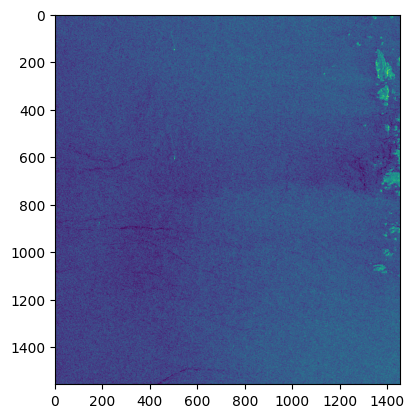

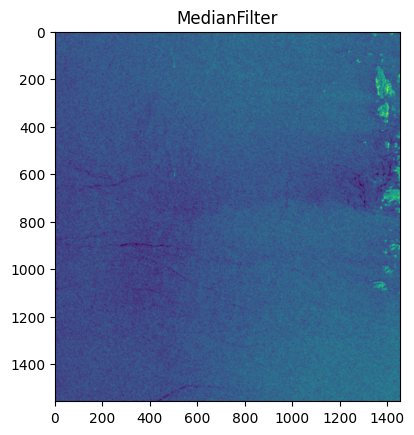

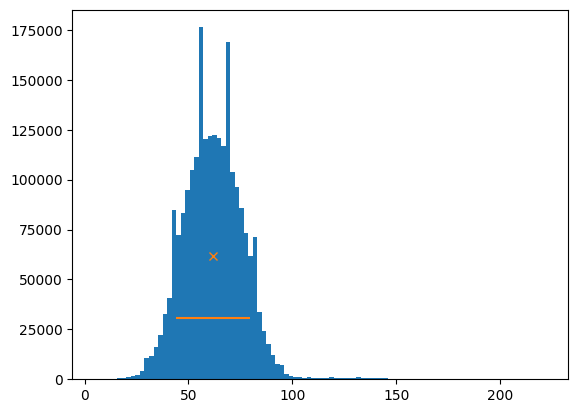

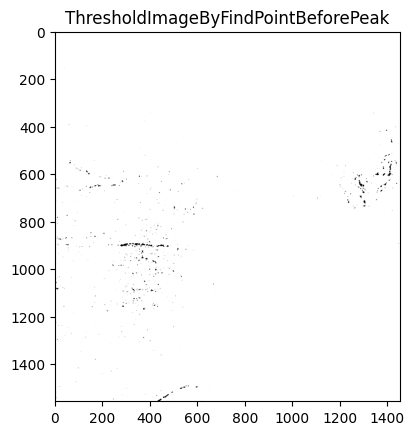

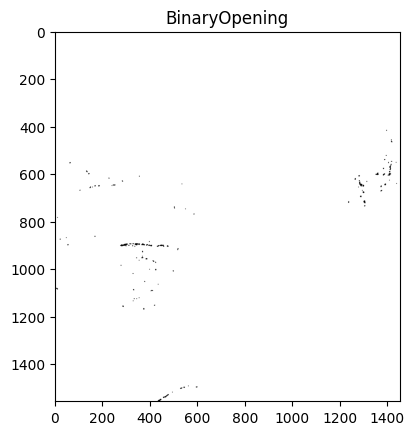

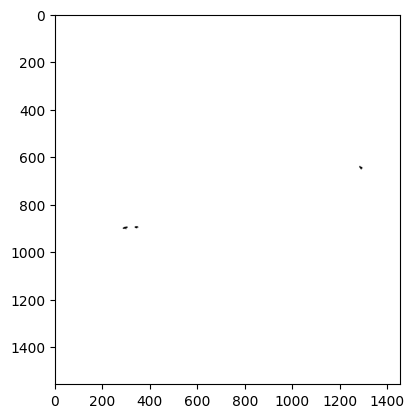

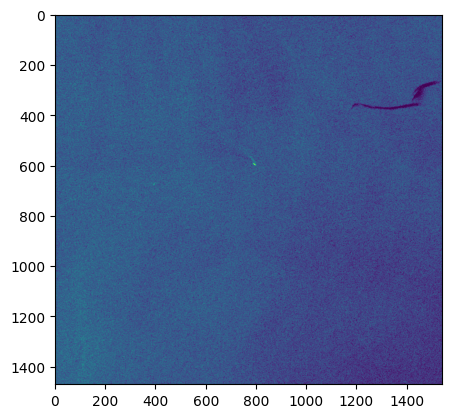

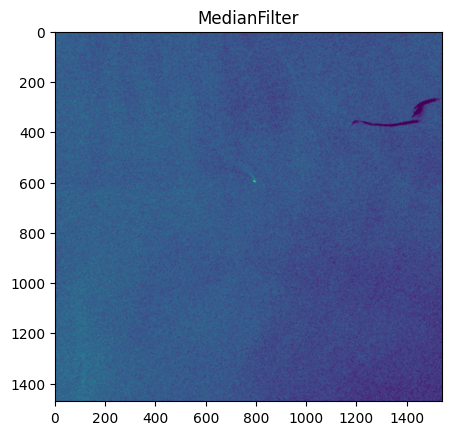

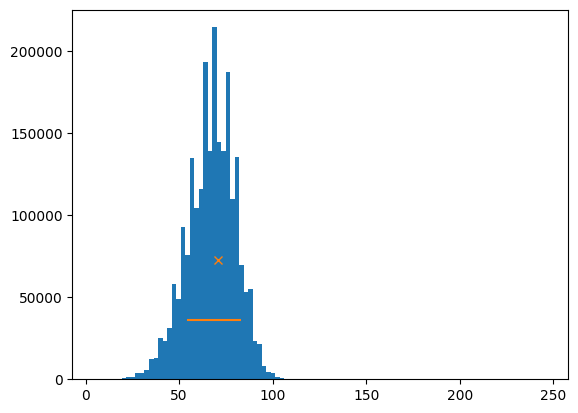

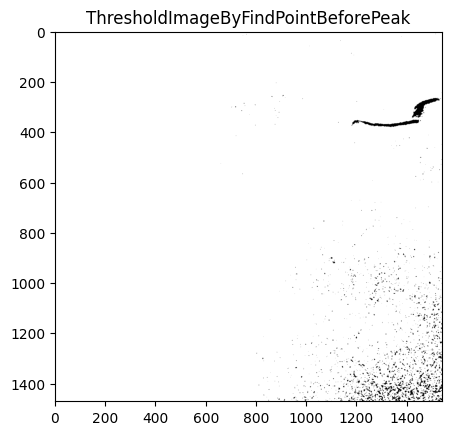

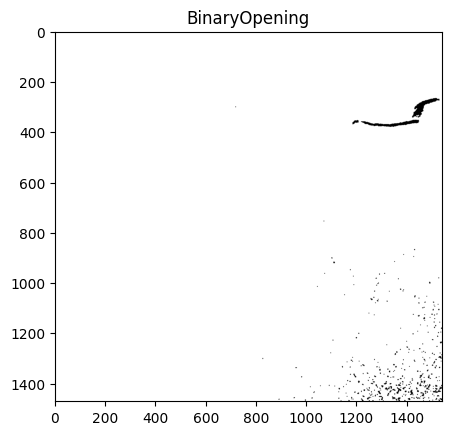

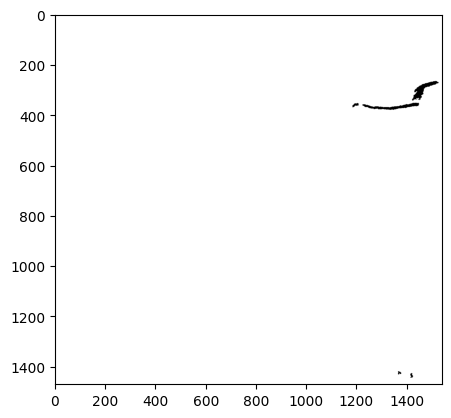

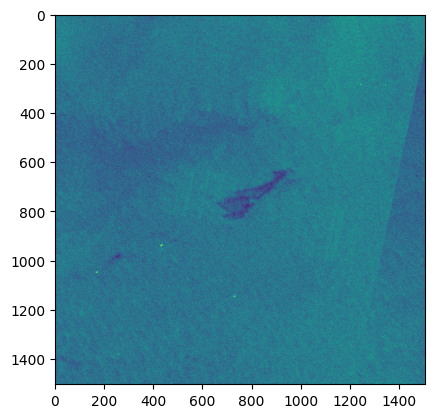

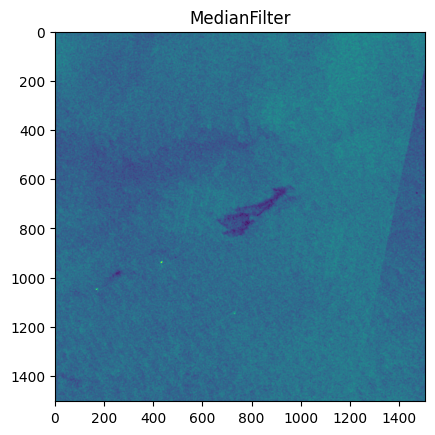

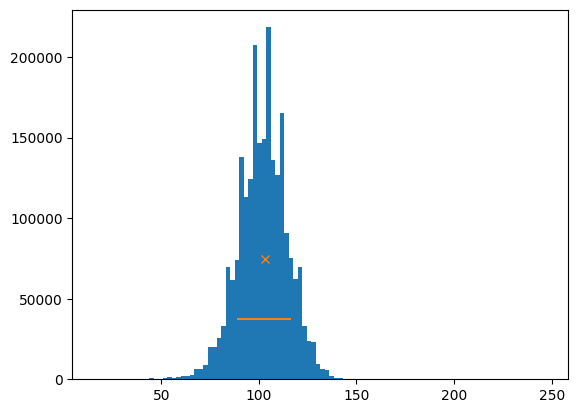

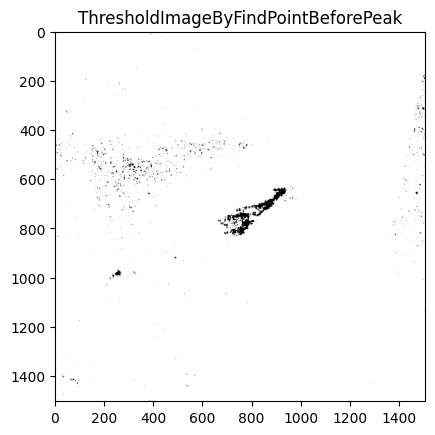

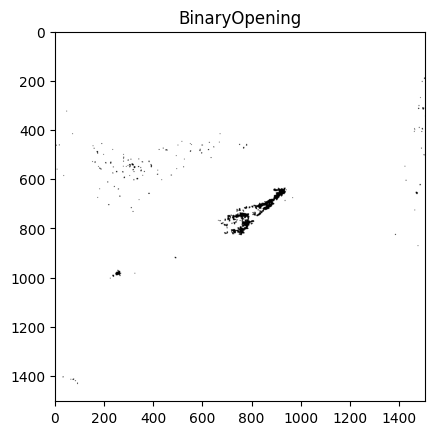

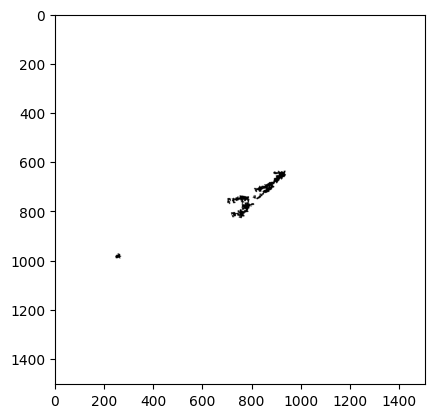

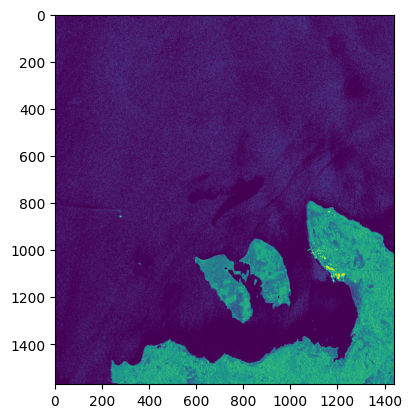

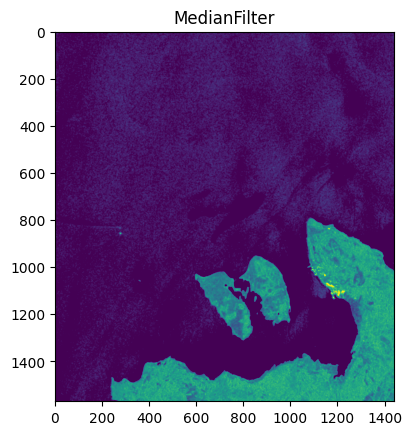

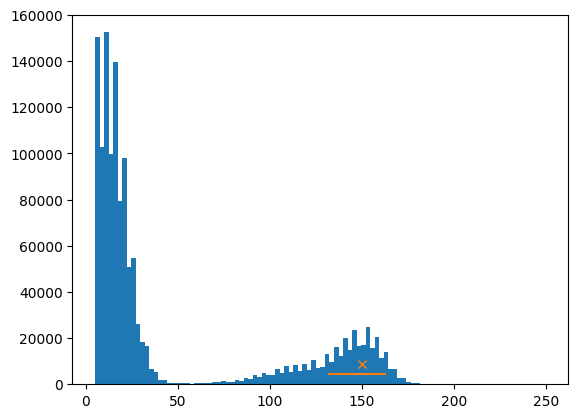

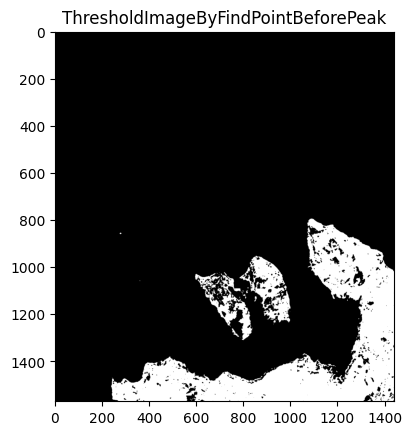

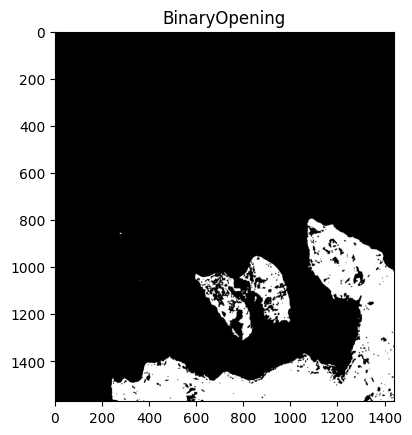

In [ ]:
verbose = True
for image_arr in images_arr_bucket:
    image_arr = image_arr[:, :, 0] # take only one channel becasue they are all the same
    if verbose:
        plt.imshow(image_arr)
        plt.show()
    process_image = pipeline.fit_transform(image_arr.copy())
    plt.imshow((process_image > 0).astype(int), vmin=0, vmax=1, cmap="binary")
    plt.show()